In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import neural_network
from sklearn.model_selection import GridSearchCV





In [ ]:
## Importing the dataset: 
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/Loan Default (Employed).csv")


## If done on local machine, uncomment this line of code:
## df = pd.read_csv("/Users/junlongng/Desktop/NTU/Year_2/Semester 2/BC3415 AI in ACC & Finance/Week 4 Regression/Homework/Loan Default (Employed).csv")


Mounted at /content/drive


In [ ]:
df.head()

,Index,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0


In [ ]:
df.drop(columns ="Index", inplace = True)

In [ ]:
df.head()

,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,8754.36,532339.56,0
1,0,9806.16,145273.56,0
2,1,12882.60,381205.68,0
3,1,6351.00,428453.88,0
4,1,9427.92,461562.00,0


In [ ]:
df['Defaulted_Status'] = df['Defaulted?']
df.drop(columns ="Defaulted?", inplace=True)

In [ ]:
df.head()

,Employed,Bank Balance,Annual Salary,Defaulted_Status
0,1,8754.36,532339.56,0
1,0,9806.16,145273.56,0
2,1,12882.60,381205.68,0
3,1,6351.00,428453.88,0
4,1,9427.92,461562.00,0


In [ ]:
df['Defaulted_Status'].value_counts()

0    9667
1     333
Name: Defaulted_Status, dtype: int64

In [ ]:
## Oversample of case 1

<h2> Data Viz 

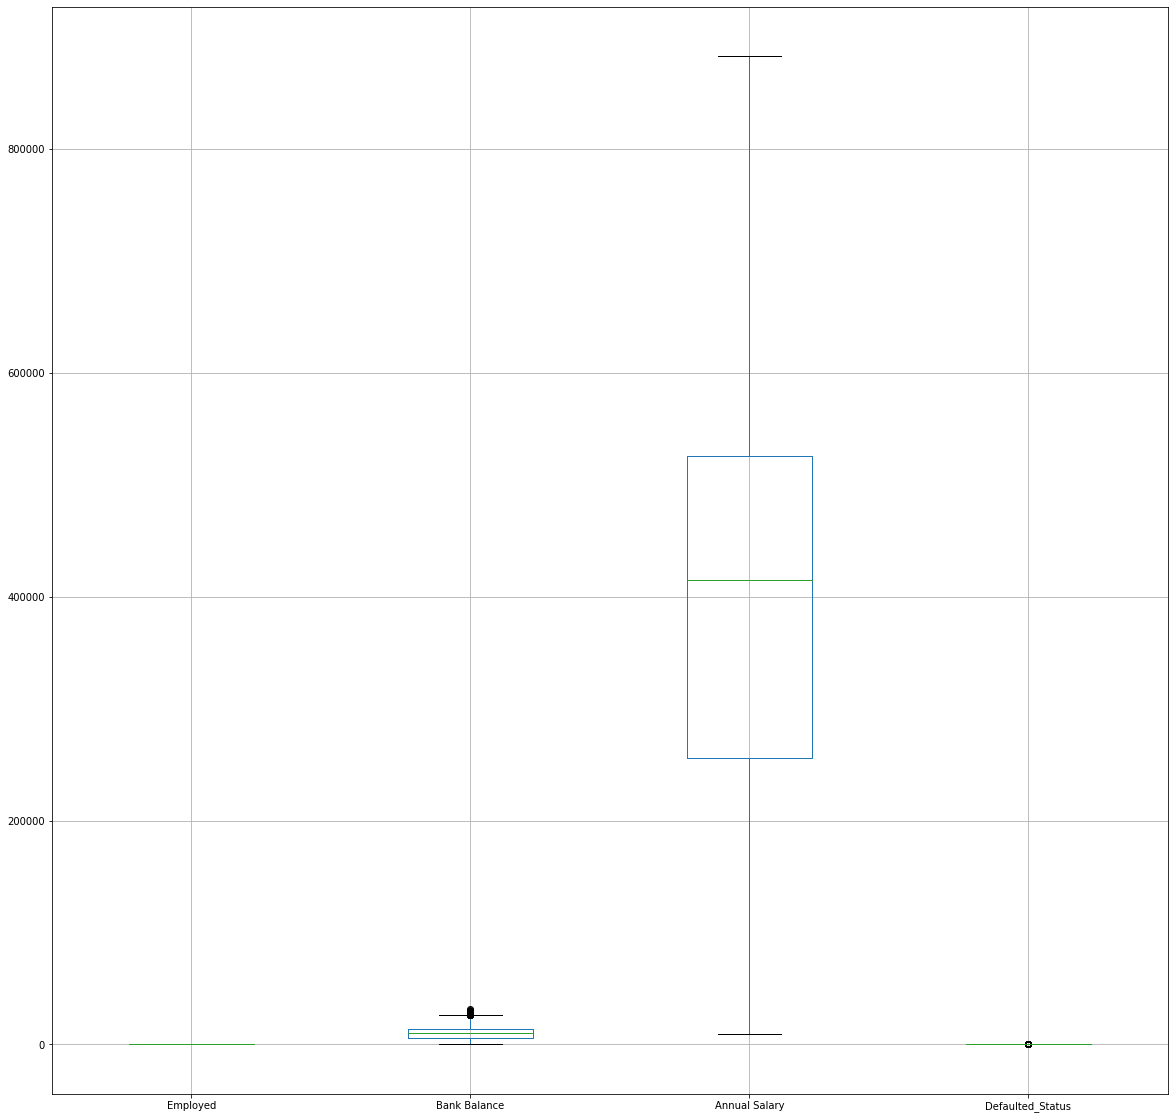

In [ ]:
df.boxplot(figsize=(20,20))

In [ ]:
## Need to normalize Annual Salary. The range is too wide as compared to the rest of the variables


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49303a5a60>,
      dtype=object)

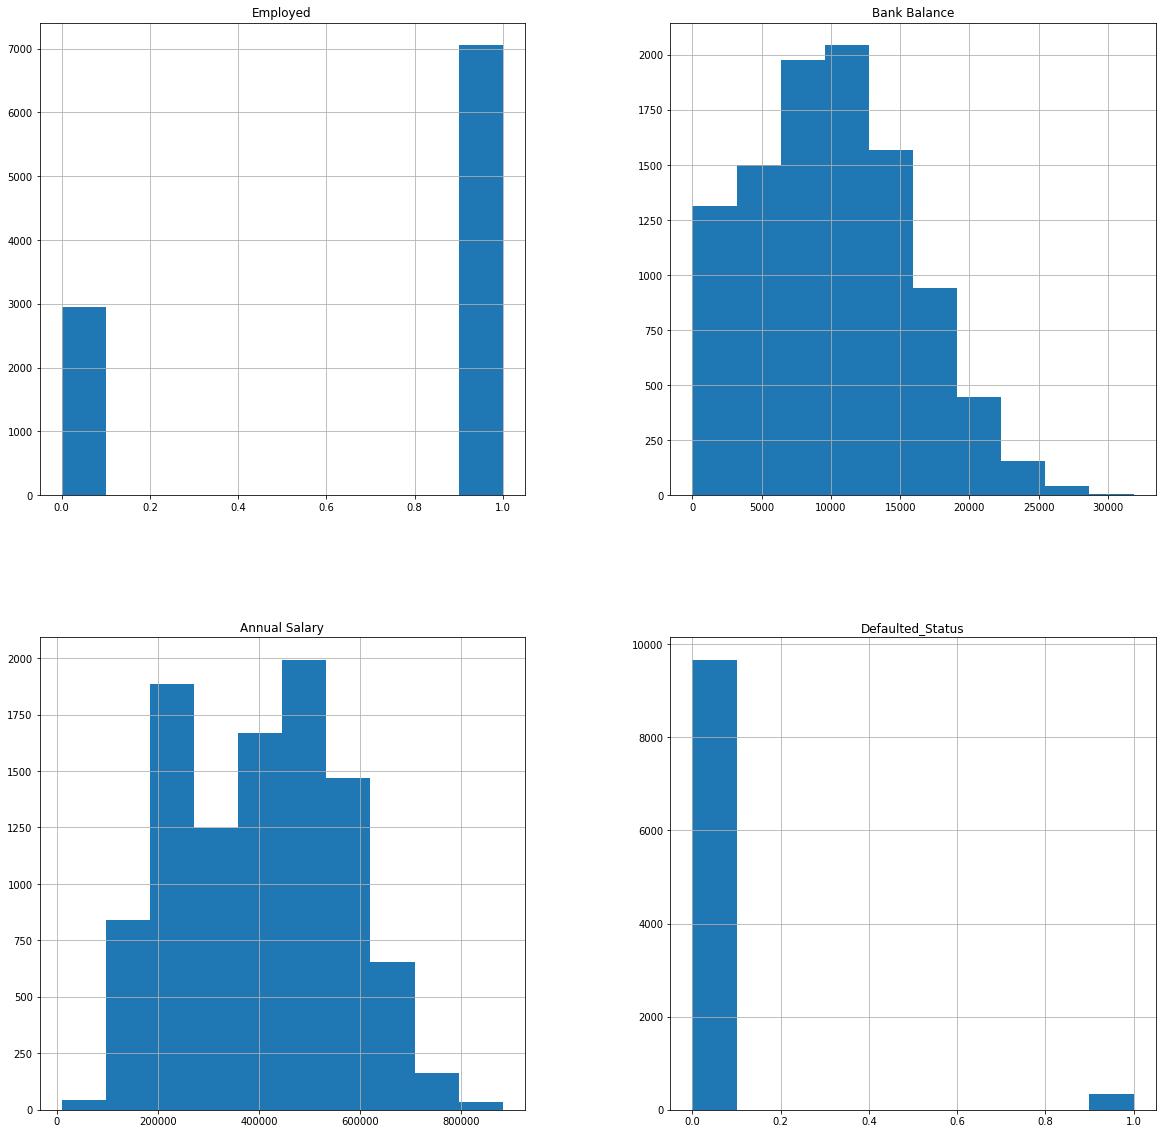

In [ ]:
df.hist(figsize=(20,20))

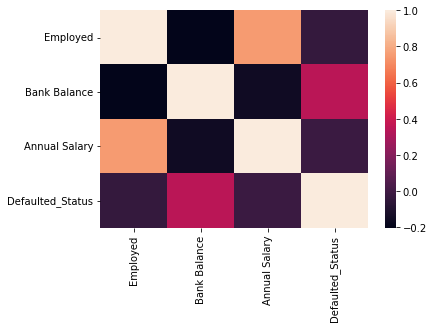

In [ ]:
sns.heatmap(df.corr())

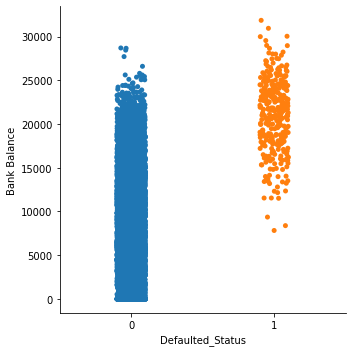

In [ ]:
sns.catplot(data=df, x="Defaulted_Status", y="Bank Balance")

Normalizing Annual Salary & Bank Balance

In [ ]:
#def normalize_zscore(df, column_names):
#    for column_name in column_names:
#        mean = df[column_name].mean()
#        std = df[column_name].std()
#        df[column_name] = (df[column_name] - mean) / std
#    return df


def normalize_column(df, column_name):
    scaler = StandardScaler()
    data = df[column_name].values.reshape(-1, 1)
    normalized_data = scaler.fit_transform(data)
    df[column_name] = normalized_data
    return df


normalized_df = normalize_column(df, 'Annual Salary')
normalized_df = normalize_column(normalized_df,'Bank Balance')


In [ ]:
normalized_df.describe()

,Employed,Bank Balance,Annual Salary,Defaulted_Status
count,10000.000000,1.000000e+04,1.000000e+04,10000.000000
mean,0.705600,-8.988366e-17,-1.524114e-16,0.033300
std,0.455795,1.000050e+00,1.000050e+00,0.179428
min,0.000000,-1.727085e+00,-2.455390e+00,0.000000
25%,0.000000,-7.311332e-01,-9.130584e-01,0.000000
50%,1.000000,-2.427145e-02,7.765936e-02,0.000000
75%,1.000000,6.841770e-01,7.716534e-01,0.000000
max,1.000000,3.760554e+00,3.002199e+00,1.000000


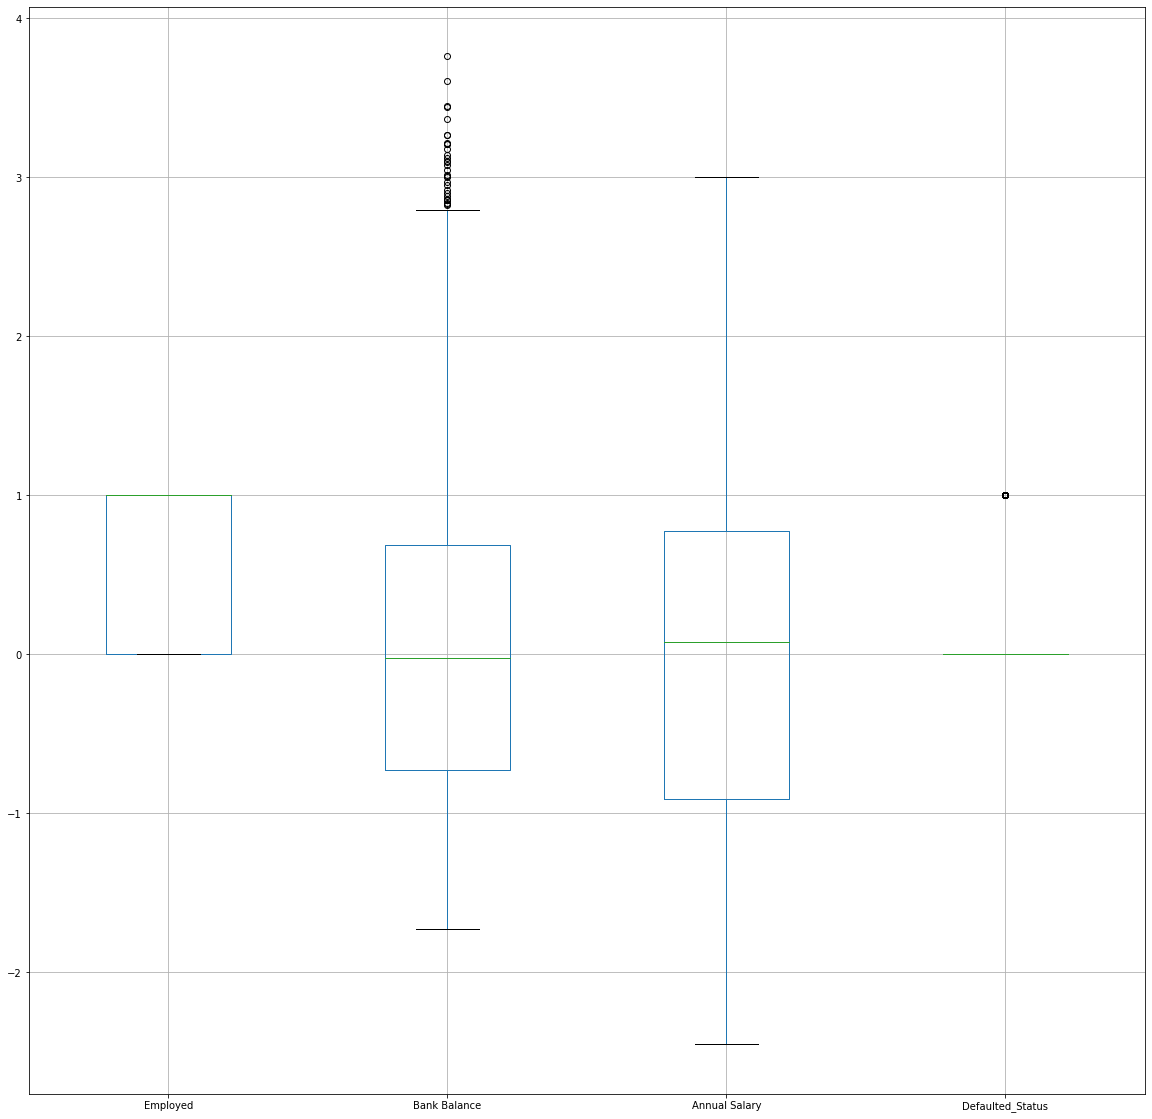

In [ ]:
normalized_df.boxplot(figsize=(20,20))

<h2> Encoding Employed & Default Status from int to categorical

In [ ]:
def one_hot_encode(df, column_name):
    one_hot = pd.get_dummies(df[column_name], prefix=column_name)
    df = df.drop(column_name, axis=1)
    df = df.join(one_hot)
    return df

normalized_df = one_hot_encode(normalized_df, 'Employed')


<h2> Encoding Defaulted Status

In [ ]:
temp_normalized_df = one_hot_encode(normalized_df, 'Defaulted_Status')

In [ ]:
normalized_df.describe()

,Bank Balance,Annual Salary,Defaulted_Status,Employed_0,Employed_1
count,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,-8.988366e-17,-1.524114e-16,0.033300,0.294400,0.705600
std,1.000050e+00,1.000050e+00,0.179428,0.455795,0.455795
min,-1.727085e+00,-2.455390e+00,0.000000,0.000000,0.000000
25%,-7.311332e-01,-9.130584e-01,0.000000,0.000000,0.000000
50%,-2.427145e-02,7.765936e-02,0.000000,0.000000,1.000000
75%,6.841770e-01,7.716534e-01,0.000000,1.000000,1.000000
max,3.760554e+00,3.002199e+00,1.000000,1.000000,1.000000


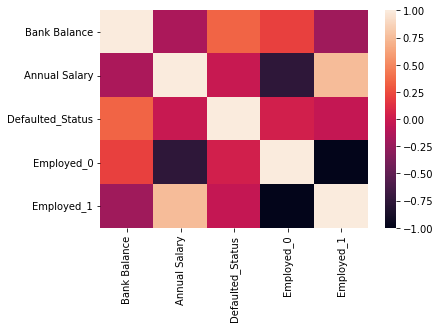

In [ ]:
sns.heatmap(normalized_df.corr())

<h2> Now we can see more accurately what affects default status 

<h3> Reflection 
<p> After normalizing the data, we can see that Default Status is most correlated with Bank Balance.

<h2> Due Dilligence on Data Sets

In [ ]:
x = normalized_df.drop(columns = "Defaulted_Status")
# x = normalized_df.drop(columns = "Defaulted_Status_0")
# normalized = normalized_df.drop(columns = "Defaulted_Status_1")
y = normalized_df['Defaulted_Status']

<h3> Checking for VIF 

In [ ]:
#vif to check collinearity 
#1 = not correlated.
#Between 1 and 5 = moderately correlated.
#Greater than 5 = highly correlated.
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]
print(vif_data)


         feature       VIF
0   Bank Balance  1.043240
1  Annual Salary  2.317473
2     Employed_0  1.960769
3     Employed_1  1.400865


<h2> QQ Plot to check heteroscedasticity

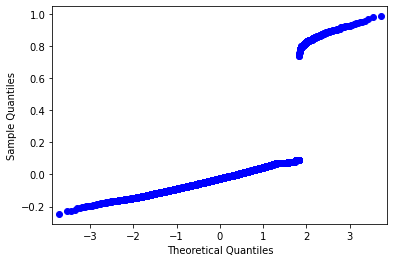

In [ ]:
import statsmodels.api as sm
from matplotlib import pyplot as plt
mod_fit = sm.OLS(y,x).fit()
res = mod_fit.resid # residuals
fig = sm.qqplot(res)
plt.show()

<h2> Anova Check For Significance

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
model = ols("y ~ x", df).fit()
print(model.summary())
anova_results = anova_lm(model)
print('\nANOVA results')
print(anova_results)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     471.7
Date:                Fri, 03 Feb 2023   Prob (F-statistic):          1.09e-286
Time:                        10:57:39   Log-Likelihood:                 3653.0
No. Observations:               10000   AIC:                            -7298.
Df Residuals:                    9996   BIC:                            -7269.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0208      0.001     15.255      0.0

<h2> Creating the train test split:

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=42)

<h2> Balancing the Data:

In [ ]:
from imblearn.over_sampling import SMOTE
y_train.value_counts()
model = SMOTE()
x_train, y_train = model.fit_resample(x_train,y_train)
## Only rebalance the train data for both X and Y, never the test data

In [ ]:
y_train.value_counts()

0    7248
1    7248
Name: Defaulted_Status, dtype: int64

<h1> By this stage, I've already normalized before splitting. Need to ask professor what are the consequence for doing this.

<h2> Developing a Logistic Model Classifier

In [ ]:
log_model = linear_model.LogisticRegression()
log_model.fit(x_train,y_train)
log_pred = log_model.predict(x_test)
cm = confusion_matrix(y_test,log_pred)
cm

array([[2109,  310],
       [   9,   72]])

In [ ]:
print("Logistic model accuracy: " , (cm[0,0]+cm[1,1])/(sum(sum(cm))))


Logistic model accuracy:  0.8724


<h3> How did i manage to get a 100% accuracy model?

<h2> Building a CART TREE

In [ ]:
CART_model = tree.DecisionTreeClassifier(random_state = 42)
CART_model.fit(x_train,y_train)
CART_pred = CART_model.predict(x_test)
cm = confusion_matrix(y_test,CART_pred)
cm

array([[2196,  223],
       [  35,   46]])

In [ ]:
print("CART model accuracy: " , (cm[0,0]+cm[1,1])/(sum(sum(cm))))

CART model accuracy:  0.8968


<h2> Building an ensemble classification model

In [ ]:
Ensemble_model = ensemble.RandomForestClassifier()
Ensemble_model.fit(x_train, y_train)
Ensemble_pred = Ensemble_model.predict(x_test)
cm = confusion_matrix(y_test,Ensemble_pred)
cm

array([[2203,  216],
       [  33,   48]])

In [ ]:
print("Ensemble accuracy", (cm[0,0]+cm[1,1])/(sum(sum(cm))))

Ensemble accuracy 0.9004


<h2> Building a neural network model

In [ ]:
NN_model = neural_network.MLPClassifier(max_iter = 500)
NN_model.fit(x_train,y_train)
NN_pred = NN_model.predict(x_test)
cm = confusion_matrix(y_test,NN_pred)
cm

array([[2119,  300],
       [  12,   69]])

In [ ]:
print("NN accuracy", (cm[0,0]+cm[1,1])/(sum(sum(cm))))


NN accuracy 0.8752


<h2> Seems like the best performing model is Random Forest Classifier Model </h2>

<p> To increase the accuracy, we could use GridSearchCV:

In [ ]:
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_depth': [None, 3, 5, 7, 9],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 3, 5, 7, 9]
}


In [ ]:
clf = ensemble.RandomForestClassifier(random_state=42)

Ensemble_model = ensemble.RandomForestClassifier()


# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(x_train, y_train)


# Evaluate the accuracy on the test set
test_accuracy = grid_search.score(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Get the best hyperparameters found by grid search
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")


Test Accuracy: 0.90
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 40}
